In [ ]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from utils import *
from data_loader import load_data
from CNNs import *
from CNN_datasets import WaveformDataset

In [2]:
final_clean_strained = load_data(db_level=0)
# Strain binary: 'C57B6' = 1, 'CBA/CaJ' = 0
final_clean_strained_70 = final_clean_strained[final_clean_strained['Level(dB)'] >= 70]
final_clean_strained_80 = final_clean_strained[final_clean_strained['Level(dB)'] == 80]

In [3]:
final_clean_strained_avg = final_clean_strained.groupby(['Subject', 'Frequency(kHz)', 'Level(dB)']).agg(
    {'Amplitude': 'mean',
     'vx': 'first',
     'SynapsesPerIHC': 'mean', 
     'IHCs': 'mean',
     'OrphansPerIHC': 'mean',
     'Waveform': 'first',
     'WaveI': 'first',
     'Peaks': 'first',
     'Troughs': 'first',
     'Strain': 'first',
     'Sex': 'first',
     'Group': 'first',
     'Noise': 'mean',
     'Time (str)': 'first',
     'Time (hrs)': 'first',
     'Strain (binary)': 'first',
    }).reset_index()

In [5]:
def split_by_mouse(data, 
                   split_on='Subject', 
                   stratify_on='Group', 
                   test_size=0.2, 
                   val_size=0.18, 
                   random_state=1,
                   return_idx=False):
    mice = data[[split_on, stratify_on]].drop_duplicates().set_index(split_on)

    train, test = train_test_split(mice.index, 
                                   test_size=test_size, 
                                   shuffle=True,
                                   stratify=mice[stratify_on], 
                                   random_state=random_state)

    train_indices = data[split_on].isin(train)
    test_indices = data[split_on].isin(test)

    train2, val = train_test_split(train,
                                   test_size=val_size,
                                   shuffle=True,
                                   stratify=mice.loc[train]['Group'],
                                   random_state=random_state)

    train2_indices = data[split_on].isin(train2)
    val_indices = data[split_on].isin(val)

    data['DataGroup'] = ''
    data.loc[train2_indices, 'DataGroup'] = 'Train'
    data.loc[val_indices, 'DataGroup'] = 'Validate'
    data.loc[test_indices, 'DataGroup'] = 'Test'
    if return_idx:
        return data, train_indices, train2_indices, val_indices, test_indices
    return data

In [25]:
use_dataset = final_clean_strained_70 #final_clean_strained_avg

use_dataset, train_indices, train2_indices, val_indices, test_indices = split_by_mouse(use_dataset, return_idx=True)
test_results = use_dataset[test_indices].copy()
use_dataset['DataGroup'].value_counts()

DataGroup
Train       1754
Test         600
Validate     406
Name: count, dtype: int64

In [45]:
class WaveformDatasetWithFreq(Dataset):
    def __init__(self, df, data='waveform'):
        self.df = df
        self.data = data
        self.waveforms, self.targets, self.frequencies, self.strains = self.prepare_data(df)
    
    def prepare_data(self, df):
        waveforms = []
        targets = []
        frequencies = []
        strains = []
        
        for idx, row in df.iterrows():
            if self.data == 'waveform':
                orig_y = row['Waveform']
                waveform = self.preprocess_waveform(orig_y, 20)
            elif self.data == 'wavei':
                waveform = row['WaveI']
            
            waveforms.append(waveform)
            targets.append(row['SynapsesPerIHC']/20)
            frequencies.append(row['Frequency(kHz)']/45.2)
            strains.append(row['Strain (binary)'])

        return waveforms, targets, frequencies, strains

    def preprocess_waveform(self, waveform, time_scale):
        orig_y = waveform
        tenms = int((10/time_scale)*len(orig_y)) if time_scale > 10 else len(orig_y)
        return interpolate_and_smooth(orig_y[:tenms], 244)

    def __len__(self):
        return len(self.waveforms)
    
    def __getitem__(self, idx):
        waveform = self.waveforms[idx].copy()
        
        waveform_tensor = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0)
        target_tensor = torch.tensor(self.targets[idx], dtype=torch.float32)
        frequency_tensor = torch.tensor(self.frequencies[idx], dtype=torch.float32)
        strain_tensor = torch.tensor(self.strains[idx], dtype=torch.float32)
        return waveform_tensor, target_tensor, frequency_tensor, strain_tensor

class WaveICNNWithFrequency(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(WaveICNNWithFrequency, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)  # 30 -> 30
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)  # 30 -> 30
        
        self.pool = nn.MaxPool1d(2)  # 30 -> 15 -> 7 (with padding)
        self.dropout = nn.Dropout(dropout_rate)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(34, 16), #32 pooled features + frequency + strain
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 1)
        )
        
    def forward(self, x, frequency, strain):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # (batch_size, 16, 15)
    
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch_size, 32, 7)
        
        x = self.dropout(x)
        
        # Global pooling
        x = self.global_pool(x).squeeze(-1)  # (batch_size, 32)
        x = torch.cat([x, frequency, strain], dim=1)  # (batch_size, 34)
        
        # Fully connected layers
        x = self.fc(x)
        return x    

def train_cnn_model_with_freq(train_loader, val_loader, num_epochs=100, 
                    ):
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f"Using device: {device}")

    model = WaveICNNWithFrequency(dropout_rate=0.3)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # Training loop
    train_losses = []
    val_losses = []
    
    print_every = num_epochs // 10 if num_epochs >= 10 else 1
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            waveform, target, frequency, strain = data
            waveform, target, frequency, strain = waveform.to(device), target.to(device), frequency.to(device).unsqueeze(1), strain.to(device).unsqueeze(1)

            output = model(waveform, frequency, strain)
            loss = criterion(output.squeeze(), target)
            
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for waveform, target, frequency, strain in val_loader:
                waveform, target, frequency, strain = waveform.to(device), target.to(device), frequency.to(device).unsqueeze(1), strain.to(device).unsqueeze(1)
                output = model(waveform, frequency, strain)
                loss = criterion(output.squeeze(), target)
                val_loss += loss.item()

        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)
        
        # print progress
        if epoch % print_every == 0:
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return model, train_losses, val_losses

Using device: mps
Epoch 0/150, Train Loss: 0.1589, Val Loss: 0.0407
Epoch 15/150, Train Loss: 0.0355, Val Loss: 0.0254
Epoch 30/150, Train Loss: 0.0306, Val Loss: 0.0234
Epoch 45/150, Train Loss: 0.0309, Val Loss: 0.0235
Epoch 60/150, Train Loss: 0.0300, Val Loss: 0.0235
Epoch 75/150, Train Loss: 0.0289, Val Loss: 0.0233
Epoch 90/150, Train Loss: 0.0290, Val Loss: 0.0234
Epoch 105/150, Train Loss: 0.0287, Val Loss: 0.0234
Epoch 120/150, Train Loss: 0.0290, Val Loss: 0.0234
Epoch 135/150, Train Loss: 0.0293, Val Loss: 0.0234


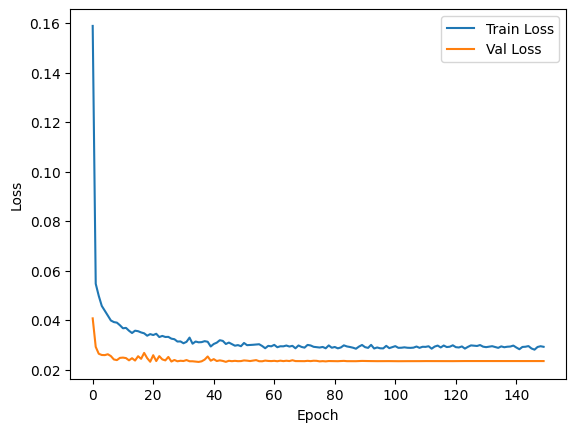

CNN with Frequency Input R²: 0.229


In [46]:
traindataset_with_freq = WaveformDatasetWithFreq(
    final_clean_strained_70[train2_indices], 
    data='wavei')
valdataset_with_freq = WaveformDatasetWithFreq(
    final_clean_strained_70[val_indices], 
    data='wavei')
testdataset_with_freq = WaveformDatasetWithFreq(
    final_clean_strained_70[test_indices],
    data='wavei')
train_loader_with_freq = DataLoader(traindataset_with_freq, batch_size=64, shuffle=True)
val_loader_with_freq = DataLoader(valdataset_with_freq, batch_size=64, shuffle=False)
test_loader_with_freq = DataLoader(testdataset_with_freq, batch_size=64, shuffle=False)

model_with_freq, train_losses_with_freq, val_losses_with_freq = train_cnn_model_with_freq(
    train_loader_with_freq, 
    val_loader_with_freq, 
    num_epochs=150
)

plt.plot(train_losses_with_freq, label='Train Loss' )
plt.plot(val_losses_with_freq, label='Val Loss')
#plt.ylim([0,100])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Evaluate on test set
model_with_freq.eval()
preds_with_freq = []
targets_with_freq = []
with torch.no_grad():
    for waveform, target, frequency, strain in test_loader_with_freq:
        if torch.backends.mps.is_available():
            device = torch.device('mps')
        elif torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        waveform, target, frequency, strain = waveform.to(device), target.to(device), frequency.to(device).unsqueeze(1), strain.to(device).unsqueeze(1)
        output = model_with_freq(waveform, frequency, strain)
        preds_with_freq.extend(output.squeeze().cpu().numpy())
        targets_with_freq.extend(target.cpu().numpy())

r2_with_freq = r2_score(targets_with_freq, preds_with_freq)
print(f'CNN with Frequency Input R²: {r2_with_freq:.3f}')

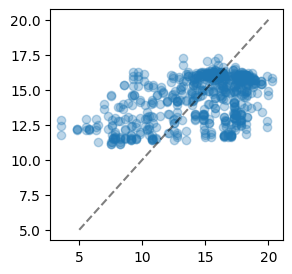

In [50]:
plt.figure(figsize=(3,3))
plt.plot([i*20 for i in targets_with_freq], [i*20 for i in preds_with_freq],'o', alpha=0.3)
plt.plot([5,20],[5,20],'k--', alpha=0.5)


### Feature Prediction

Using device: mps
Epoch 0/50, Train Loss: 110.4003 (Syn: 106.5824, Amp: 3.8180), Val Loss: 12.5935, Best Val Loss: inf
Epoch 5/50, Train Loss: 24.7201 (Syn: 24.1935, Amp: 0.5266), Val Loss: 13.2800, Best Val Loss: 12.0289
Epoch 10/50, Train Loss: 23.0635 (Syn: 22.5830, Amp: 0.4805), Val Loss: 15.3383, Best Val Loss: 11.8662
Epoch 15/50, Train Loss: 22.2974 (Syn: 21.8256, Amp: 0.4718), Val Loss: 12.5937, Best Val Loss: 11.7439
Epoch 20/50, Train Loss: 22.6893 (Syn: 22.2075, Amp: 0.4818), Val Loss: 11.7928, Best Val Loss: 11.7439
Epoch 25/50, Train Loss: 21.2302 (Syn: 20.7525, Amp: 0.4777), Val Loss: 12.0396, Best Val Loss: 11.7228
Epoch 30/50, Train Loss: 20.7092 (Syn: 20.2022, Amp: 0.5070), Val Loss: 14.2180, Best Val Loss: 11.7228
Epoch 35/50, Train Loss: 20.5492 (Syn: 20.0542, Amp: 0.4950), Val Loss: 11.8032, Best Val Loss: 11.7228
Epoch 40/50, Train Loss: 20.5475 (Syn: 20.0410, Amp: 0.5065), Val Loss: 12.4770, Best Val Loss: 11.7228
Early stopping at epoch 43


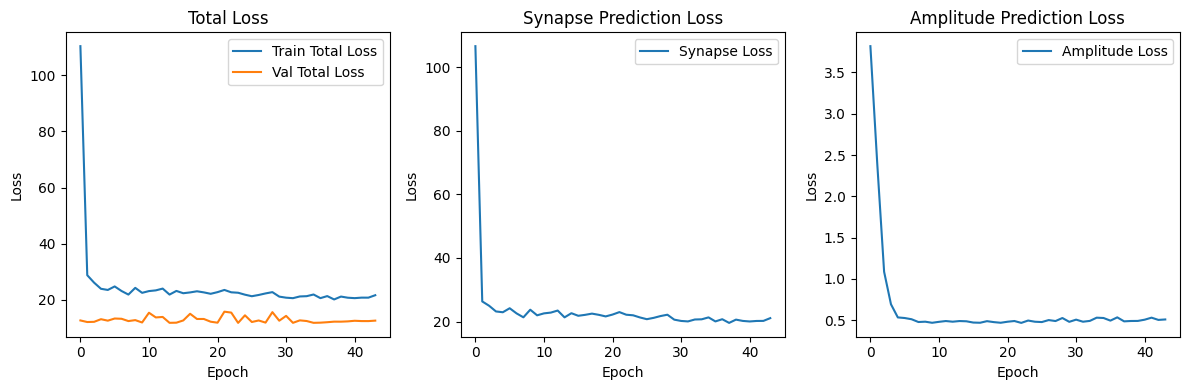

In [26]:
train_dataset = WaveformDataset(use_dataset[train2_indices], augment=True, augment_prob=0.7, feature_pred=True)
val_dataset = WaveformDataset(use_dataset[val_indices], augment=False, feature_pred=True)
test_dataset = WaveformDataset(use_dataset[test_indices], augment=False, feature_pred=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

feature_model, train_losses, val_losses, syn_losses, amp_losses = train_cnn_model(
    train_loader, val_loader, num_epochs=50, model_type='feature_pred', #early_stop=False
)

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Total Loss')
plt.plot(val_losses, label='Val Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Total Loss')

plt.subplot(1, 3, 2)
plt.plot(syn_losses, label='Synapse Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Synapse Prediction Loss')

plt.subplot(1, 3, 3)
plt.plot(amp_losses, label='Amplitude Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Amplitude Prediction Loss')

plt.tight_layout()
plt.show()

In [27]:
feature_model.eval()
    
synapse_predictions = []
amp_predictions = []

with torch.no_grad():
    for waveform, synapse_target, amplitude_target in test_loader:
        synapse_pred, amplitude_pred = feature_model(waveform)
        
        synapse_predictions.extend(synapse_pred.squeeze().numpy())
        amp_predictions.extend(amplitude_pred.squeeze().numpy())

# Convert to numpy arrays
synapse_predictions = np.array(synapse_predictions)
amp_predictions = np.array(amp_predictions)

test_results['Feature CNN Predictions'] = synapse_predictions
test_results['Feature CNN Amplitude Predictions'] = amp_predictions

# print r2:
r2_syn = r2_score(test_results['SynapsesPerIHC'], test_results['Feature CNN Predictions'])
r2_amp = r2_score(test_results['Amplitude'], test_results['Feature CNN Amplitude Predictions'])
print(f'Feature CNN Synapse R²: {r2_syn:.3f}')
print(f'Feature CNN Amplitude R²: {r2_amp:.3f}')

Feature CNN Synapse R²: 0.118
Feature CNN Amplitude R²: 0.241


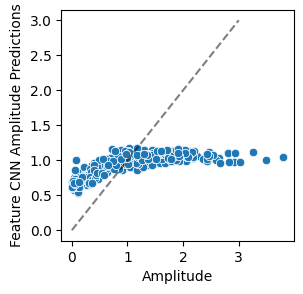

In [28]:
plt.figure(figsize=(3,3))
sns.scatterplot(test_results, x='Amplitude', y='Feature CNN Amplitude Predictions')
plt.plot([0, 3], [0,3], 'k--', alpha=0.5)

### Feature guided

In [29]:
train_dataset = WaveformDataset(
    use_dataset[train2_indices], 
    augment=False, feature_pred=True  
)
val_dataset = WaveformDataset(
    use_dataset[val_indices], 
    augment=False, feature_pred=True
)
test_dataset = WaveformDataset(
    use_dataset[test_indices], 
    augment=False, feature_pred=True
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train the feature-guided model
feature_guided_model, train_losses, val_losses, syn_losses, amp_losses = train_cnn_model(
    train_loader, val_loader, num_epochs=100, model_type='feature_guided', early_stop=False
)

Using device: mps
Epoch 0/100, Train Loss: 165.5142 (Syn: 164.0155, Amp: 1.4987), Val Loss: 35.4655, Best Val Loss: inf
Epoch 10/100, Train Loss: 16.9324 (Syn: 16.4508, Amp: 0.4816), Val Loss: 10.7382, Best Val Loss: 10.6487
Epoch 20/100, Train Loss: 15.8098 (Syn: 15.4452, Amp: 0.3646), Val Loss: 10.2191, Best Val Loss: 10.2776
Epoch 30/100, Train Loss: 15.6322 (Syn: 15.3069, Amp: 0.3254), Val Loss: 10.5735, Best Val Loss: 9.9192
Epoch 40/100, Train Loss: 14.9864 (Syn: 14.7162, Amp: 0.2702), Val Loss: 9.7717, Best Val Loss: 9.7056
Epoch 50/100, Train Loss: 14.1191 (Syn: 13.8702, Amp: 0.2488), Val Loss: 9.5852, Best Val Loss: 9.5340
Epoch 60/100, Train Loss: 14.0481 (Syn: 13.7760, Amp: 0.2721), Val Loss: 9.6950, Best Val Loss: 9.5340
Epoch 70/100, Train Loss: 14.1854 (Syn: 13.9301, Amp: 0.2554), Val Loss: 9.4838, Best Val Loss: 9.4718
Epoch 80/100, Train Loss: 13.7981 (Syn: 13.5417, Amp: 0.2564), Val Loss: 9.4686, Best Val Loss: 9.4643
Epoch 90/100, Train Loss: 13.7073 (Syn: 13.4441, Am

In [30]:

# Evaluate
feature_guided_model.eval()
synapse_predictions = []
amp_predictions = []

with torch.no_grad():
    for waveform, synapse_target, amplitude_target in test_loader:
        synapse_pred, amplitude_pred = feature_guided_model(waveform)
        synapse_predictions.extend(synapse_pred.squeeze().numpy())
        amp_predictions.extend(amplitude_pred.squeeze().numpy())

synapse_predictions = np.array(synapse_predictions)
amp_predictions = np.array(amp_predictions)

r2_syn = r2_score(test_results['SynapsesPerIHC'], synapse_predictions)
r2_amp = r2_score(test_results['Amplitude'], amp_predictions)
test_results['Feature-guided CNN Predictions'] = synapse_predictions
print(f'Feature-Guided CNN Synapse R²: {r2_syn:.3f}')
print(f'Feature-Guided CNN Amplitude R²: {r2_amp:.3f}')


Feature-Guided CNN Synapse R²: 0.115
Feature-Guided CNN Amplitude R²: 0.667



Training WaveI CNN model... wavei
Using device: mps
Epoch 0/200, Train Loss: 224.0854, Val Loss: 223.0114, Best Val Loss: inf
Epoch 20/200, Train Loss: 22.2161, Val Loss: 9.6719, Best Val Loss: 9.6004
Epoch 40/200, Train Loss: 21.0004, Val Loss: 9.4790, Best Val Loss: 9.2504
Early stopping at epoch 53


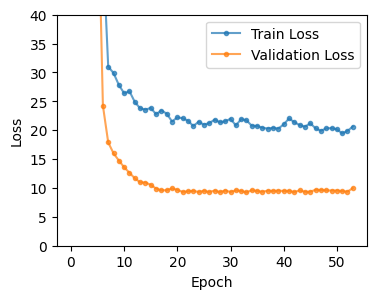

Test Set RMSE: 3.3701
Test Set R²: 0.1113

Training WaveI CNN2 model... minimal_wavei
Using device: mps
Epoch 0/200, Train Loss: 220.7445, Val Loss: 221.4055, Best Val Loss: inf
Epoch 20/200, Train Loss: 139.7429, Val Loss: 137.0109, Best Val Loss: 145.9490
Epoch 40/200, Train Loss: 15.3660, Val Loss: 12.7061, Best Val Loss: 13.2731
Epoch 60/200, Train Loss: 14.0332, Val Loss: 10.7150, Best Val Loss: 10.7479
Epoch 80/200, Train Loss: 13.5095, Val Loss: 10.0573, Best Val Loss: 10.0883
Epoch 100/200, Train Loss: 13.0442, Val Loss: 9.6058, Best Val Loss: 9.6292
Epoch 120/200, Train Loss: 12.6878, Val Loss: 9.4250, Best Val Loss: 9.4197
Epoch 140/200, Train Loss: 12.5205, Val Loss: 9.3608, Best Val Loss: 9.3541
Epoch 160/200, Train Loss: 12.4854, Val Loss: 9.2702, Best Val Loss: 9.2772
Epoch 180/200, Train Loss: 12.2576, Val Loss: 9.2155, Best Val Loss: 9.2129


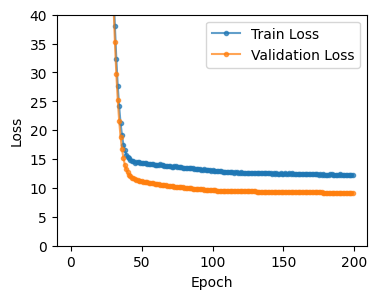

Test Set RMSE: 3.4803
Test Set R²: 0.0522

Training CNN model... default
Using device: mps
Epoch 0/100, Train Loss: 83.8918, Val Loss: 15.6194, Best Val Loss: inf
Epoch 10/100, Train Loss: 10.1202, Val Loss: 9.9417, Best Val Loss: 9.4661
Epoch 20/100, Train Loss: 9.6805, Val Loss: 9.2621, Best Val Loss: 9.3170
Epoch 30/100, Train Loss: 8.6447, Val Loss: 10.0218, Best Val Loss: 9.2621
Epoch 40/100, Train Loss: 8.0179, Val Loss: 9.5085, Best Val Loss: 9.2621
Early stopping at epoch 40


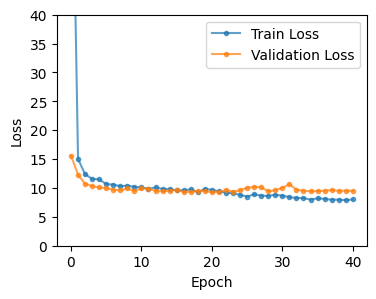

Test Set RMSE: 3.3909
Test Set R²: 0.1003

Training CNN2 model... improved
Using device: mps
Epoch 0/100, Train Loss: 97.0386, Val Loss: 11.4648, Best Val Loss: inf
Epoch 10/100, Train Loss: 19.9771, Val Loss: 13.2051, Best Val Loss: 11.1721
Epoch 20/100, Train Loss: 18.5147, Val Loss: 11.6472, Best Val Loss: 11.1721
Early stopping at epoch 27


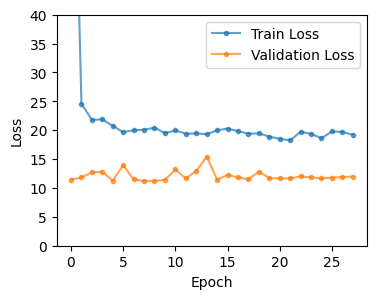

Test Set RMSE: 3.3278
Test Set R²: 0.1334


In [31]:
for name, model in zip(['WaveI CNN', 'WaveI CNN2', 'CNN', 'CNN2'], 
                         ['wavei', 'minimal_wavei', 'default', 'improved']):
    print(f'\nTraining {name} model... {model}')
    if 'wavei' in model:
        data = 'wavei'
        augment_prob = 0.3
        epochs = 200
    else:
        data = 'waveform'
        augment_prob = 0.7
        epochs = 100
    train_dataset = WaveformDataset(use_dataset[train2_indices], data=data, augment=True, augment_prob=augment_prob)
    val_dataset = WaveformDataset(use_dataset[val_indices], data=data, augment=False)
    test_dataset = WaveformDataset(use_dataset[test_indices], data=data, augment=False)

    if 'wavei' in model:
        batch_size = 64*2
    else:
        batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Train the model
    trained_model, train_losses, val_losses = train_cnn_model(train_loader, val_loader, model_type=model, num_epochs=epochs)

    plt.figure(figsize=(4,3))
    plt.plot(train_losses, 'o-', label='Train Loss', markersize=3, alpha=0.7)
    plt.plot(val_losses, 'o-', label='Validation Loss', markersize=3, alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 40])
    plt.legend()
    plt.show()


    # Make predictions on test set
    trained_model.eval()
    test_predictions = []
    test_actuals = []

    with torch.no_grad():
        for data, target in test_loader:
            output = trained_model(data)
            test_predictions.extend(output.squeeze().numpy())
            test_actuals.extend(target.numpy())

    # Convert to numpy arrays
    test_predictions = np.array(test_predictions)
    test_actuals = np.array(test_actuals)

    # Calculate metrics
    test_rmse = np.sqrt(np.mean((test_actuals - test_predictions)**2))
    ss_res = np.sum((test_actuals - test_predictions) ** 2)
    ss_tot = np.sum((test_actuals - np.mean(test_actuals)) ** 2)
    test_r2 = 1 - (ss_res / ss_tot)

    print(f'Test Set RMSE: {test_rmse:.4f}')
    print(f'Test Set R²: {test_r2:.4f}')

    test_results[name+' Predictions'] = test_predictions
    

In [32]:
preds_by_mouse_freq = test_results.groupby(['Subject', 'Frequency(kHz)']).agg(
    {'WaveI CNN Predictions': 'mean',
     'WaveI CNN2 Predictions': 'mean',
     'CNN2 Predictions': 'mean',
     'CNN Predictions': 'mean',
     'Feature-guided CNN Predictions': 'mean',
    #  'CNN Aug Predictions': 'mean',
     'SynapsesPerIHC': 'mean', 
     'Amplitude': 'mean',
     'Group': 'first', 
     'Noise': 'mean'}).reset_index()
preds_by_mouse_freq.head()


,Subject,Frequency(kHz),WaveI CNN Predictions,WaveI CNN2 Predictions,CNN2 Predictions,CNN Predictions,Feature-guided CNN Predictions,SynapsesPerIHC,Amplitude,Group,Noise
0,WPZ125,8.0,14.561523,15.653831,15.539067,14.956122,14.479959,14.197400,1.694995,94dB 8wks post,0.94
1,WPZ125,11.3,15.187469,16.875832,15.397137,16.420639,15.278140,14.952899,2.317226,94dB 8wks post,0.94
2,WPZ125,16.0,15.229582,17.353031,14.992239,15.463156,15.106763,17.973711,2.521616,94dB 8wks post,0.94
3,WPZ125,22.6,14.990032,15.733234,14.867519,15.261927,15.571209,13.847059,1.737887,94dB 8wks post,0.94
4,WPZ125,32.0,12.470257,13.533527,14.289344,11.934501,13.595026,12.072595,0.340450,94dB 8wks post,0.94


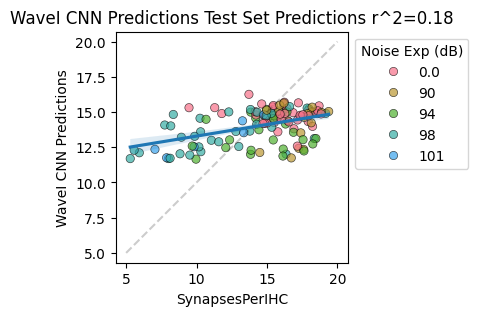

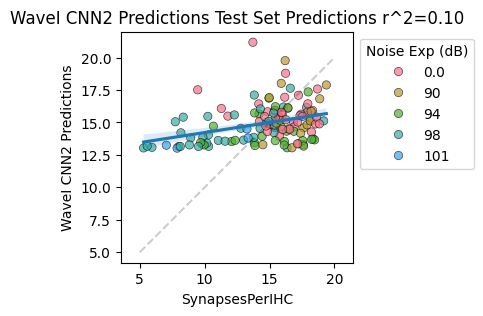

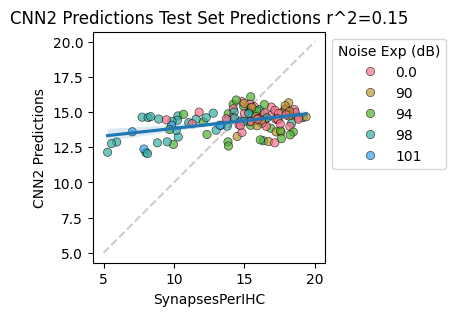

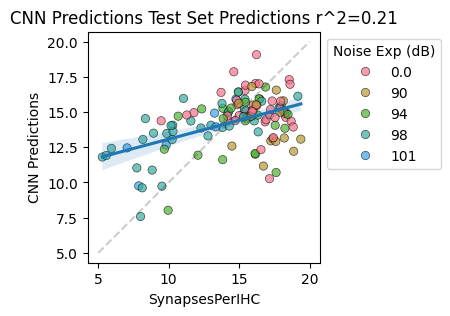

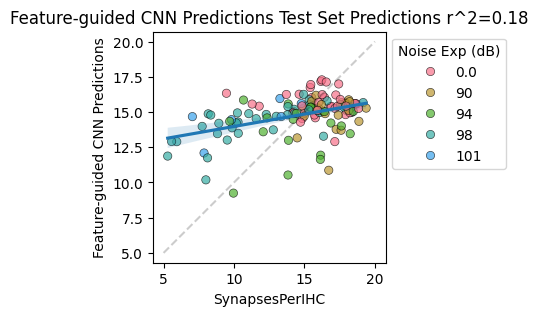

In [33]:
def reformat_legend(legend):
    new_labels = [f'{int(float(label.get_text())*100)}' for label in legend.texts[1:]]
    for t, l in zip(plt.gca().get_legend().texts[1:], new_labels):
        t.set_text(l)

predicted_columns = [x for x in preds_by_mouse_freq.columns if 'Predictions' in x]
for pred in predicted_columns:

    plt.figure(figsize=(3,3))
    plt.plot([5,20],[5,20],'k--', alpha=0.2)
    sns.scatterplot(preds_by_mouse_freq, x='SynapsesPerIHC', y=pred, hue='Noise', palette=sns.color_palette("husl", 6), alpha=0.7, edgecolor='black')
    plt.xlabel('GT Synapses/IHC')
    plt.ylabel('Predicted Synapses/IHC')
    plt.legend(title='Noise Exp (dB)', loc='upper left', bbox_to_anchor=(1, 1))
    reformat_legend(plt.gca().get_legend())
    # add best fit line:
    sns.regplot(preds_by_mouse_freq, x='SynapsesPerIHC', y=pred, scatter=False)
    plt.xlim([0, 30])
    plt.ylim([0, 30])
    plt.axis('equal')
    r2 = r2_score(preds_by_mouse_freq['SynapsesPerIHC'], preds_by_mouse_freq[pred])
    plt.title(f'{pred} Test Set Predictions r^2={r2:.2f}')
    plt.show()
    

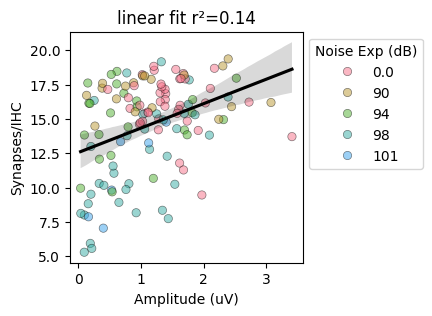

In [34]:
plt.figure(figsize=(3,3))
sns.scatterplot(preds_by_mouse_freq, x='Amplitude', y='SynapsesPerIHC', hue='Noise', palette=sns.color_palette("husl", 6), alpha=0.5, edgecolor='black')
# plot best fit line:
sns.regplot(preds_by_mouse_freq, x='Amplitude', y='SynapsesPerIHC', scatter=False, color='black')
#r2 of best fit line:
linear_fit = np.polyfit(preds_by_mouse_freq['Amplitude'], preds_by_mouse_freq['SynapsesPerIHC'], 1)
r2 = r2_score(preds_by_mouse_freq['SynapsesPerIHC'], np.polyval(linear_fit, preds_by_mouse_freq['Amplitude']))
plt.xlabel('Amplitude (uV)')
plt.ylabel('Synapses/IHC')
plt.title('linear fit r²={:.2f}'.format(r2))
plt.legend(title='Noise Exp (dB)', loc='upper left', bbox_to_anchor=(1, 1))
reformat_legend(plt.gca().get_legend())
plt.show()


In [35]:
class WaveformDatasetWithFreq(Dataset):
    def __init__(self, df, data='waveform'):
        self.df = df
        self.data = data
        self.waveforms, self.targets, self.frequencies = self.prepare_data(df)
    
    def prepare_data(self, df):
        waveforms = []
        targets = []
        frequencies = []
        
        for idx, row in df.iterrows():
            if self.data == 'waveform':
                orig_y = row['Waveform']
                waveform = self.preprocess_waveform(orig_y, 20)
            elif self.data == 'wavei':
                waveform = row['WaveI']
            
            waveforms.append(waveform)
            targets.append(row['SynapsesPerIHC']/20)
            frequencies.append(row['Frequency(kHz)']/45.2)
        
        return waveforms, targets, frequencies
    
    def preprocess_waveform(self, waveform, time_scale):
        orig_y = waveform
        tenms = int((10/time_scale)*len(orig_y)) if time_scale > 10 else len(orig_y)
        return interpolate_and_smooth(orig_y[:tenms], 244)

    def __len__(self):
        return len(self.waveforms)
    
    def __getitem__(self, idx):
        waveform = self.waveforms[idx].copy()
        
        waveform_tensor = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0)
        target_tensor = torch.tensor(self.targets[idx], dtype=torch.float32)
        frequency_tensor = torch.tensor(self.frequencies[idx], dtype=torch.float32)
        return waveform_tensor, target_tensor, frequency_tensor

class WaveICNNWithFrequency(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(WaveICNNWithFrequency, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)  # 30 -> 30
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)  # 30 -> 30
        
        self.pool = nn.MaxPool1d(2)  # 30 -> 15 -> 7 (with padding)
        
        self.dropout = nn.Dropout(dropout_rate)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(33, 16), #32 pooled features + 1 frequency
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 1)
        )
        
    def forward(self, x, frequency):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # (batch_size, 16, 15)
    
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch_size, 32, 7)
        
        x = self.dropout(x)
        
        # Global pooling
        x = self.global_pool(x).squeeze(-1)  # (batch_size, 32)
        x = torch.cat([x, frequency], dim=1)  # (batch_size, 33)
        
        # Fully connected layers
        x = self.fc(x)
        return x    

def train_cnn_model_with_freq(train_loader, val_loader, num_epochs=100, 
                    ):
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f"Using device: {device}")

    model = WaveICNNWithFrequency(dropout_rate=0.3)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # Training loop
    train_losses = []
    val_losses = []
    
    print_every = num_epochs // 10 if num_epochs >= 10 else 1
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            waveform, target, frequency = data
            waveform, target, frequency = waveform.to(device), target.to(device), frequency.to(device).unsqueeze(1)

            output = model(waveform, frequency)
            loss = criterion(output.squeeze(), target)
            
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for waveform, target, frequency in val_loader:
                waveform, target, frequency = waveform.to(device), target.to(device), frequency.to(device).unsqueeze(1)
                output = model(waveform, frequency)
                loss = criterion(output.squeeze(), target)
                val_loss += loss.item()

        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)
        
        # print progress
        if epoch % print_every == 0:
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return model, train_losses, val_losses

Using device: mps
Epoch 0/150, Train Loss: 0.4283, Val Loss: 0.1017
Epoch 15/150, Train Loss: 0.0521, Val Loss: 0.0237
Epoch 30/150, Train Loss: 0.0388, Val Loss: 0.0235
Epoch 45/150, Train Loss: 0.0368, Val Loss: 0.0243
Epoch 60/150, Train Loss: 0.0349, Val Loss: 0.0241
Epoch 75/150, Train Loss: 0.0340, Val Loss: 0.0239
Epoch 90/150, Train Loss: 0.0335, Val Loss: 0.0240
Epoch 105/150, Train Loss: 0.0345, Val Loss: 0.0240
Epoch 120/150, Train Loss: 0.0345, Val Loss: 0.0240
Epoch 135/150, Train Loss: 0.0325, Val Loss: 0.0240


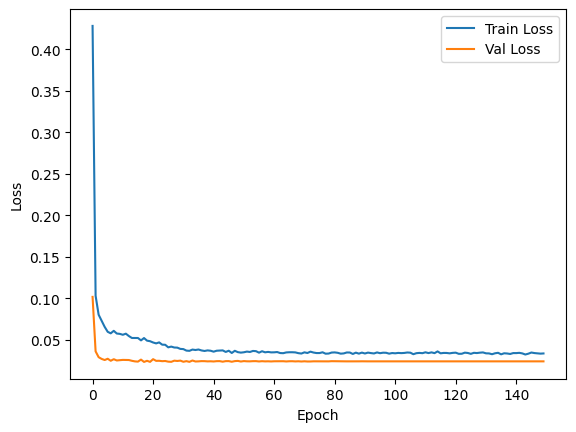

CNN with Frequency Input R²: 0.170


In [36]:
traindataset_with_freq = WaveformDatasetWithFreq(
    final_clean_strained_70[train2_indices], 
    data='wavei')
valdataset_with_freq = WaveformDatasetWithFreq(
    final_clean_strained_70[val_indices], 
    data='wavei')
testdataset_with_freq = WaveformDatasetWithFreq(
    final_clean_strained_70[test_indices],
    data='wavei')
train_loader_with_freq = DataLoader(traindataset_with_freq, batch_size=64, shuffle=True)
val_loader_with_freq = DataLoader(valdataset_with_freq, batch_size=64, shuffle=False)
test_loader_with_freq = DataLoader(testdataset_with_freq, batch_size=64, shuffle=False)

model_with_freq, train_losses_with_freq, val_losses_with_freq = train_cnn_model_with_freq(
    train_loader_with_freq, 
    val_loader_with_freq, 
    num_epochs=150
)

plt.plot(train_losses_with_freq, label='Train Loss' )
plt.plot(val_losses_with_freq, label='Val Loss')
#plt.ylim([0,100])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Evaluate on test set
model_with_freq.eval()
preds_with_freq = []
targets_with_freq = []
with torch.no_grad():
    for waveform, target, frequency in test_loader_with_freq:
        if torch.backends.mps.is_available():
            device = torch.device('mps')
        elif torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        waveform, target, frequency = waveform.to(device), target.to(device), frequency.to(device).unsqueeze(1)
        output = model_with_freq(waveform, frequency)
        preds_with_freq.extend(output.squeeze().cpu().numpy())
        targets_with_freq.extend(target.cpu().numpy())

r2_with_freq = r2_score(targets_with_freq, preds_with_freq)
print(f'CNN with Frequency Input R²: {r2_with_freq:.3f}')

Using device: mps
Epoch 0/150, Train Loss: 0.5190, Val Loss: 0.2898
Epoch 15/150, Train Loss: 0.0548, Val Loss: 0.0253
Epoch 30/150, Train Loss: 0.0466, Val Loss: 0.0243
Epoch 45/150, Train Loss: 0.0393, Val Loss: 0.0258
Epoch 60/150, Train Loss: 0.0383, Val Loss: 0.0239
Epoch 75/150, Train Loss: 0.0371, Val Loss: 0.0239
Epoch 90/150, Train Loss: 0.0358, Val Loss: 0.0242
Epoch 105/150, Train Loss: 0.0352, Val Loss: 0.0242
Epoch 120/150, Train Loss: 0.0374, Val Loss: 0.0242
Epoch 135/150, Train Loss: 0.0365, Val Loss: 0.0242


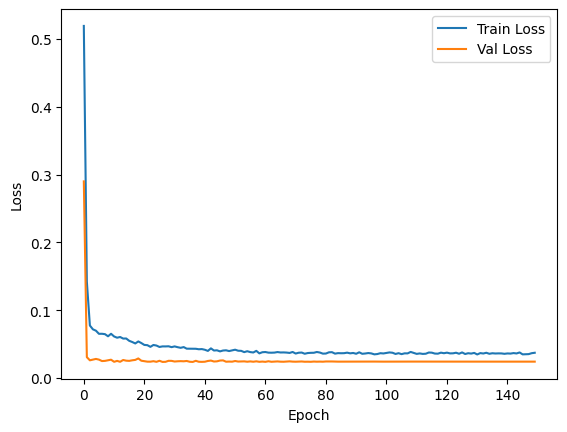

CNN with Frequency Input R²: 0.146


In [37]:
class WaveDataset(Dataset):
    def __init__(self, df, data='waveform'):
        self.df = df
        self.data = data
        self.waveforms, self.targets = self.prepare_data(df)
    
    def prepare_data(self, df):
        waveforms = []
        targets = []
        
        for idx, row in df.iterrows():
            if self.data == 'waveform':
                orig_y = row['Waveform']
                waveform = self.preprocess_waveform(orig_y, 20)
            elif self.data == 'wavei':
                waveform = row['WaveI']
            
            waveforms.append(waveform)
            targets.append(row['SynapsesPerIHC']/20)
        
        return waveforms, targets
    
    def preprocess_waveform(self, waveform, time_scale):
        orig_y = waveform
        tenms = int((10/time_scale)*len(orig_y)) if time_scale > 10 else len(orig_y)
        return interpolate_and_smooth(orig_y[:tenms], 244)

    def __len__(self):
        return len(self.waveforms)
    
    def __getitem__(self, idx):
        waveform = self.waveforms[idx].copy()
        
        waveform_tensor = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0)
        target_tensor = torch.tensor(self.targets[idx], dtype=torch.float32)
        return waveform_tensor, target_tensor

class WaveICNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(WaveICNN, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)  # 30 -> 30
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)  # 30 -> 30
        
        self.pool = nn.MaxPool1d(2)  # 30 -> 15 -> 7 (with padding)
        
        self.dropout = nn.Dropout(dropout_rate)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(32, 16), 
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # (batch_size, 16, 15)
    
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch_size, 32, 7)
        
        x = self.dropout(x)
        
        # Global pooling
        x = self.global_pool(x).squeeze(-1)  # (batch_size, 32)
        
        # Fully connected layers
        x = self.fc(x)
        return x    

def train_cnn_model_without_freq(train_loader, val_loader, num_epochs=100, 
                    ):
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f"Using device: {device}")

    model = WaveICNN(dropout_rate=0.3)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # Training loop
    train_losses = []
    val_losses = []
    
    print_every = num_epochs // 10 if num_epochs >= 10 else 1
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            waveform, target = data
            waveform, target = waveform.to(device), target.to(device), 
            output = model(waveform)
            loss = criterion(output.squeeze(), target)
            
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for waveform, target in val_loader:
                waveform, target = waveform.to(device), target.to(device), 
                output = model(waveform)
                loss = criterion(output.squeeze(), target)
                val_loss += loss.item()

        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)
        
        # print progress
        if epoch % print_every == 0:
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return model, train_losses, val_losses

traindataset_with_freq = WaveDataset(
    final_clean_strained_70[train2_indices], 
    data='wavei')
valdataset_with_freq = WaveDataset(
    final_clean_strained_70[val_indices], 
    data='wavei')
testdataset_with_freq = WaveDataset(
    final_clean_strained_70[test_indices],
    data='wavei')
train_loader_with_freq = DataLoader(traindataset_with_freq, batch_size=64, shuffle=True)
val_loader_with_freq = DataLoader(valdataset_with_freq, batch_size=64, shuffle=False)
test_loader_with_freq = DataLoader(testdataset_with_freq, batch_size=64, shuffle=False)

model_with_freq, train_losses_with_freq, val_losses_with_freq = train_cnn_model_without_freq(
    train_loader_with_freq, 
    val_loader_with_freq, 
    num_epochs=150
)

plt.plot(train_losses_with_freq, label='Train Loss' )
plt.plot(val_losses_with_freq, label='Val Loss')
#plt.ylim([0,100])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Evaluate on test set
model_with_freq.eval()
preds_with_freq = []
targets_with_freq = []
with torch.no_grad():
    for waveform, target in test_loader_with_freq:
        if torch.backends.mps.is_available():
            device = torch.device('mps')
        elif torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        waveform, target = waveform.to(device), target.to(device)
        output = model_with_freq(waveform)
        preds_with_freq.extend(output.squeeze().cpu().numpy())
        targets_with_freq.extend(target.cpu().numpy())

r2_with_freq = r2_score(targets_with_freq, preds_with_freq)
print(f'CNN with Frequency Input R²: {r2_with_freq:.3f}')

Text(0, 0.5, 'Predicted Synapses/IHC')

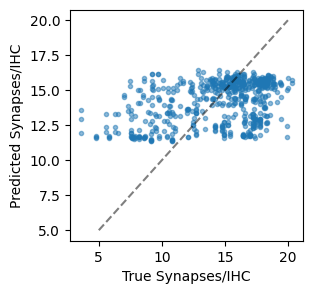

In [38]:
plt.figure(figsize=(3,3))
plt.plot([i*20 for i in targets_with_freq], [i*20 for i in preds_with_freq], '.', alpha=0.5)
plt.plot([5, 20], [5, 20], 'k--', alpha=0.5)
plt.xlabel('True Synapses/IHC')
plt.ylabel('Predicted Synapses/IHC')
